In [1]:
import scipy.stats
import imageio
import math
import numpy as np
import scipy as sp
import sys
import matplotlib.pyplot as plt
from PIL import Image
import cv2


In [2]:
def psnr(original, contrast):
    mse = np.mean((original - contrast) ** 2)
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    PSNR = 20 * math.log10(PIXEL_MAX / math.sqrt(mse))
    return PSNR


In [3]:
def refine_wideband_attentuation(uw,above_water, depths, restarts=50):

    min_depth = np.percentile(depths, 5, axis=None, out=None) 
    max_depth = np.percentile(depths, 95, axis=None, out=None) 
    pts_to_consider = np.where(np.logical_and(depths>=min_depth,depths<=max_depth))
    
    print(uw.shape,above_water.shape)

    depth_values = depths[pts_to_consider]
    above_water_pts = above_water[pts_to_consider]
    uw_pts = uw[pts_to_consider]
    
    coefs = None
    best_loss = np.inf
    def calc_image(above_water_points,a,b,c,d,Bc,beta_B):
        beta_D = a*np.exp(-b*depth_values) + c*np.exp(-d*depth_values)
        return above_water_points*np.exp(-beta_D*depth_values) + Bc*(1-np.exp(-beta_B*depth_values))

    def loss(above_water_points,a,b,c,d,Bc,beta_B):
        return np.mean(np.abs(uw_pts-calc_image(above_water_points,a,b,c,d,Bc,beta_B)))

    for _ in range(restarts):
        try:
            optp, pcov = sp.optimize.curve_fit(
                f=calc_image,
                xdata=above_water_pts,
                ydata=uw_pts,
                p0=np.abs(np.random.random(6)) * np.array([5., 7.,4.,5.,0.5,2]),
                bounds=([0, 0, 0, 0, 0, 0], [100., 100.,100.,100.,1., 5]))
            L = loss(above_water_pts,*optp)
            if L < best_loss:
                best_loss = L
                coefs = optp
        except RuntimeError as re:
            print(re, file=sys.stderr)
    # Uncomment to see the regression
    # plt.clf()
    # plt.scatter(depths[locs], estimation[locs])
    # plt.plot(np.sort(depths[locs]), calculate_beta_D(np.sort(depths[locs]), *coefs))
    # plt.show()

    print(f'Found best loss {best_loss}', flush=True)
    
    return coefs

In [4]:
above_water = imageio.imread("results/T_S03673.png")/255
under_water_og = imageio.imread("results/postprocessedT_S03673.png")/255
under_water_og = cv2.resize(under_water_og, (above_water.shape[1],above_water.shape[0]), interpolation = cv2.INTER_AREA)

In [5]:
def load_image_and_depth_map(depths_fname,dim):
    
    depths = np.array(Image.open(depths_fname))
    depth_resized = cv2.resize(depths, (dim), interpolation = cv2.INTER_AREA)
    return depth_resized

In [6]:
depths_fname = "/home/neham/uw_datasets/SeaThru_Final/SeaThru_5/depthMaps/depthT_S03673.tif"
depth_resized = load_image_and_depth_map(depths_fname,(under_water_og.shape[1],under_water_og.shape[0]))

In [7]:
depth_resized.max()

4.6524243

In [8]:
uw_red_channel = under_water_og[:,:,0]
above_water_red = above_water[:,:,0]
coeffs_R = refine_wideband_attentuation(uw_red_channel,above_water_red, depth_resized)

uw_red_channel = under_water_og[:,:,1]
above_water_red = above_water[:,:,1]
coeffs_G = refine_wideband_attentuation(uw_red_channel,above_water_red, depth_resized)

uw_red_channel = under_water_og[:,:,2]
above_water_red = above_water[:,:,2]
coeffs_B = refine_wideband_attentuation(uw_red_channel,above_water_red, depth_resized)

(341, 512) (341, 512)
Found best loss 0.022616389235114002
(341, 512) (341, 512)
Found best loss 0.05666786355569847
(341, 512) (341, 512)
Found best loss 0.04667717563636844


In [9]:
a = np.array([coeffs_R[0],coeffs_G[0],coeffs_B[0]])
b = np.array([coeffs_R[1],coeffs_G[1],coeffs_B[1]])
c = np.array([coeffs_R[2],coeffs_G[2],coeffs_B[2]])
d = np.array([coeffs_R[3],coeffs_G[3],coeffs_B[3]])
B_inf = np.array([coeffs_R[4],coeffs_G[4],coeffs_B[4]])
beta_B = np.array([coeffs_R[5],coeffs_G[5],coeffs_B[5]])

In [10]:
print(a,b,c,d,B_inf,beta_B)

[0.76768549 1.96669914 4.91883377] [1.43423646e-08 6.92417319e-01 9.40921533e-01] [64.93547642  0.45884361  3.14777482] [4.04319755 1.5526469  4.6439051 ] [0.00844119 0.43591857 0.38981669] [1.76794793 1.09835172 1.9531056 ]


In [26]:
beta_D = a*np.exp(-b*depth_resized[:,:,np.newaxis]) + c*np.exp(-d*depth_resized[:,:,np.newaxis])
under_water = above_water*np.exp(-beta_D*depth_resized[:,:,np.newaxis]) + B_inf*(1-np.exp(-beta_B*depth_resized[:,:,np.newaxis]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


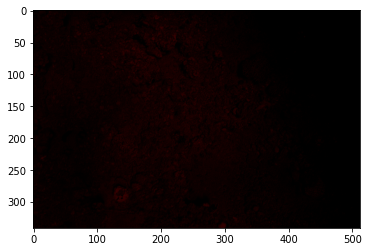

In [28]:
plt.imshow((under_water_og - B_inf*(1-np.exp(-beta_B*depth_resized[:,:,np.newaxis]))/beta_D))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


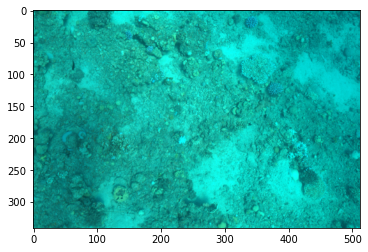

In [13]:
plt.imshow(under_water_og)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


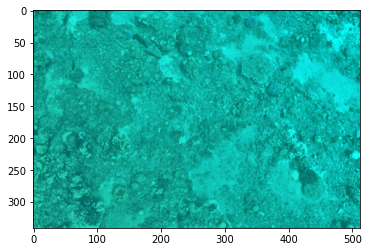

In [22]:
plt.imshow(np.abs(under_water))

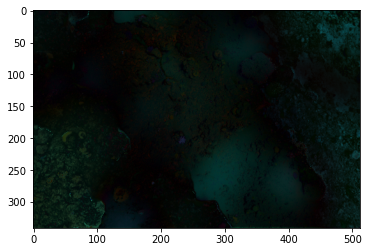

In [21]:
plt.imshow(np.abs(under_water-under_water_og))

In [15]:
psnr(np.array(under_water*255,dtype=np.uint8), np.array(under_water_og*255,dtype=np.uint8))

29.65532876434257

In [19]:
print(a,b,c,d)

[0.76768549 1.96669914 4.91883377] [1.43423646e-08 6.92417319e-01 9.40921533e-01] [64.93547642  0.45884361  3.14777482] [4.04319755 1.5526469  4.6439051 ]
